来自*GPyTorch*官方文档[GPyTorch Regression Tutorial](https://docs.gpytorch.ai/en/latest/examples/01_Exact_GPs/Simple_GP_Regression.html)

实现对一个带噪声的正弦函数的拟合:
$$y=\sin{2{\pi}x}+\epsilon$$
$$\epsilon {\space}{\sim}{\space}\mathcal{N}(0, 0.04)$$

----

In [1]:
import torch
import gpytorch
import math
from matplotlib import pyplot as plt

In [2]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

----
+ 打印训练数据

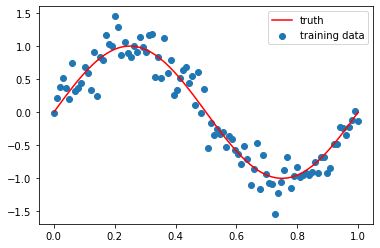

In [3]:
f, ax = plt.subplots()
ax.scatter(train_x, train_y,label='training data')
true_y = torch.sin(train_x * (2 * math.pi))
ax.plot(train_x, true_y,'r',label='truth')
ax.legend()

****

创建GP Model，继承自gptorch.models，表明是采用何种推断方法      
+ 精确推断(Exact GP Inference)    
+ 近似推断（Approximate GP Inference），特别是变分推断（variational inference）  
+ Deep GP  

对于精确推断，\__init\__()中需要告知（输入）：   
+ train_inputs   &emsp;($n{\times}d$)
+ train_targets  &emsp;($n$)
+ likelihood  &emsp;$p(y|f)$
+ 设定采用何种均值和方差形式

forward()方法输入$X$:  
$$X=\begin{bmatrix}
x_1\\
x_2\\
\vdots\\
x_n\\
\end{bmatrix}_{n\times d}$$
返回联合高斯的prior(一个多元随机变量):&emsp;$p(f|X)$

$$
\begin{bmatrix}
f(x_1)\\
f(x_2)\\
\vdots\\
f(x_n)\\
\end{bmatrix}_{n \times 1}
\sim \mathcal{GP}(\mu(X),K_{xx})
$$

Model设定了$p(y|f),p(f|X)$，在 .eval() 模式下，函数式调用model即可进行预测；

In [4]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [5]:
model

ExactGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

有关kernel中的需要经过优化确定的参数 (kernel attributes)，例如lengthscale可以查阅文档或help获得;

In [6]:
list(model.parameters())

[Parameter containing:
 tensor([0.], requires_grad=True),
 Parameter containing:
 tensor([0.], requires_grad=True),
 Parameter containing:
 tensor(0., requires_grad=True),
 Parameter containing:
 tensor([[0.]], requires_grad=True)]

+ model.parameters()输出的参数代表什么？？  

In [7]:
help(model.covar_module.base_kernel)

Help on RBFKernel in module gpytorch.kernels.rbf_kernel object:

class RBFKernel(gpytorch.kernels.kernel.Kernel)
 |  RBFKernel(ard_num_dims=None, batch_shape=torch.Size([]), active_dims=None, lengthscale_prior=None, lengthscale_constraint=None, eps=1e-06, **kwargs)
 |  
 |  Computes a covariance matrix based on the RBF (squared exponential) kernel
 |  between inputs :math:`\mathbf{x_1}` and :math:`\mathbf{x_2}`:
 |  
 |  .. math::
 |  
 |     \begin{equation*}
 |        k_{\text{RBF}}(\mathbf{x_1}, \mathbf{x_2}) = \exp \left( -\frac{1}{2}
 |        (\mathbf{x_1} - \mathbf{x_2})^\top \Theta^{-2} (\mathbf{x_1} - \mathbf{x_2}) \right)
 |     \end{equation*}
 |  
 |  where :math:`\Theta` is a :attr:`lengthscale` parameter.
 |  See :class:`gpytorch.kernels.Kernel` for descriptions of the lengthscale options.
 |  
 |  .. note::
 |  
 |      This kernel does not have an `outputscale` parameter. To add a scaling parameter,
 |      decorate this kernel with a :class:`gpytorch.kernels.ScaleKerne

In [8]:
print(model.covar_module.base_kernel.lengthscale)

tensor([[0.6931]], grad_fn=<SoftplusBackward>)


------
+ 进入.eval()模式可以进行预测；
+ with torch.no_grad():  将梯度运算隔离；

In [9]:
#如果不经过训练，直接预测会是什么样？
model.eval()
likelihood.eval()
with torch.no_grad():
    test_x = torch.linspace(0, 1, 51)
    f_preds = model(test_x)
    print(f_preds)

MultivariateNormal(loc: torch.Size([51]))


返回的是随机变量的分布，包含均值以及方差的信息；

In [10]:
help(f_preds)

Help on MultivariateNormal in module gpytorch.distributions.multivariate_normal object:

class MultivariateNormal(torch.distributions.multivariate_normal.MultivariateNormal, gpytorch.distributions.distribution.Distribution)
 |  MultivariateNormal(mean, covariance_matrix, validate_args=False)
 |  
 |  Constructs a multivariate normal random variable, based on mean and covariance.
 |  Can be multivariate, or a batch of multivariate normals
 |  
 |  Passing a vector mean corresponds to a multivariate normal.
 |  Passing a matrix mean corresponds to a batch of multivariate normals.
 |  
 |  :param torch.tensor mean: Vector n or matrix b x n mean of mvn distribution.
 |  :param ~gpytorch.lazy.LazyTensor covar: Matrix n x n or batch matrix b x n x n covariance of
 |      mvn distribution.
 |  
 |  Method resolution order:
 |      MultivariateNormal
 |      torch.distributions.multivariate_normal.MultivariateNormal
 |      gpytorch.distributions.distribution.Distribution
 |      gpytorch.dist

In [11]:
# 提取预测的后验分布在各test点的均值
with torch.no_grad():
    mean = f_preds.mean
mean

tensor([ 0.8320,  0.8208,  0.8074,  0.7918,  0.7740,  0.7540,  0.7319,  0.7076,
         0.6812,  0.6528,  0.6224,  0.5901,  0.5560,  0.5202,  0.4828,  0.4438,
         0.4035,  0.3618,  0.3190,  0.2752,  0.2305,  0.1850,  0.1389,  0.0924,
         0.0456, -0.0013, -0.0482, -0.0950, -0.1415, -0.1875, -0.2328, -0.2774,
        -0.3212, -0.3638, -0.4053, -0.4455, -0.4843, -0.5215, -0.5571, -0.5909,
        -0.6229, -0.6530, -0.6811, -0.7072, -0.7312, -0.7530, -0.7727, -0.7901,
        -0.8053, -0.8183, -0.8291])

In [12]:
with torch.no_grad():
    corvar = f_preds.variance
    print(corvar)
corvar.shape

tensor([0.0369, 0.0331, 0.0297, 0.0268, 0.0242, 0.0219, 0.0199, 0.0183, 0.0169,
        0.0157, 0.0147, 0.0140, 0.0134, 0.0129, 0.0126, 0.0123, 0.0122, 0.0121,
        0.0120, 0.0120, 0.0120, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121,
        0.0121, 0.0121, 0.0121, 0.0120, 0.0120, 0.0120, 0.0121, 0.0122, 0.0123,
        0.0126, 0.0129, 0.0134, 0.0140, 0.0147, 0.0157, 0.0169, 0.0183, 0.0199,
        0.0219, 0.0242, 0.0268, 0.0297, 0.0331, 0.0369])


torch.Size([51])

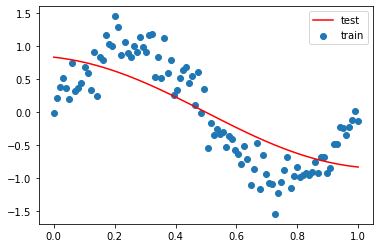

In [13]:
with torch.no_grad():
    f, ax = plt.subplots()
    ax.plot(test_x, mean, 'r',label='test')
    ax.scatter(train_x, train_y, label='train')
    ax.legend()

tensor([ 0.8320,  0.8208,  0.8074,  0.7918,  0.7740,  0.7540,  0.7319,  0.7076,
         0.6812,  0.6528,  0.6224,  0.5901,  0.5560,  0.5202,  0.4828,  0.4438,
         0.4035,  0.3618,  0.3190,  0.2752,  0.2305,  0.1850,  0.1389,  0.0924,
         0.0456, -0.0013, -0.0482, -0.0950, -0.1415, -0.1875, -0.2328, -0.2774,
        -0.3212, -0.3638, -0.4053, -0.4455, -0.4843, -0.5215, -0.5571, -0.5909,
        -0.6229, -0.6530, -0.6811, -0.7072, -0.7312, -0.7530, -0.7727, -0.7901,
        -0.8053, -0.8183, -0.8291])


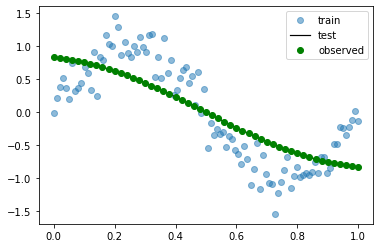

In [14]:
with torch.no_grad():
    observed_y = likelihood(f_preds)
    print(observed_y.mean)
    f, ax = plt.subplots()
    ax.plot(train_x, train_y,'o', label='train', alpha=0.5)
    ax.plot(test_x, mean, 'k',label='test',linewidth=1.2)
    ax.plot(test_x, observed_y.mean,'og',label='observed')
    ax.legend()

+ 训练：调整kernel中的参数，边际似然最大：  
$$\mathcal{mll}(\theta)=p(y|x)=\int p(y|f)p(f|x)dx$$

In [15]:
training_iter = 60
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/60 - Loss: 0.942   lengthscale: 0.693   noise: 0.693
Iter 2/60 - Loss: 0.910   lengthscale: 0.644   noise: 0.644
Iter 3/60 - Loss: 0.876   lengthscale: 0.598   noise: 0.598
Iter 4/60 - Loss: 0.838   lengthscale: 0.555   noise: 0.554
Iter 5/60 - Loss: 0.795   lengthscale: 0.514   noise: 0.513
Iter 6/60 - Loss: 0.748   lengthscale: 0.475   noise: 0.474
Iter 7/60 - Loss: 0.697   lengthscale: 0.439   noise: 0.437
Iter 8/60 - Loss: 0.645   lengthscale: 0.404   noise: 0.402
Iter 9/60 - Loss: 0.596   lengthscale: 0.372   noise: 0.369
Iter 10/60 - Loss: 0.551   lengthscale: 0.342   noise: 0.339
Iter 11/60 - Loss: 0.510   lengthscale: 0.315   noise: 0.310
Iter 12/60 - Loss: 0.473   lengthscale: 0.291   noise: 0.284
Iter 13/60 - Loss: 0.438   lengthscale: 0.272   noise: 0.259
Iter 14/60 - Loss: 0.404   lengthscale: 0.256   noise: 0.237
Iter 15/60 - Loss: 0.371   lengthscale: 0.243   noise: 0.216
Iter 16/60 - Loss: 0.339   lengthscale: 0.232   noise: 0.196
Iter 17/60 - Loss: 0.307   length

In [16]:
list(model.parameters())

[Parameter containing:
 tensor([-3.0309], requires_grad=True),
 Parameter containing:
 tensor([0.1011], requires_grad=True),
 Parameter containing:
 tensor(0.3127, requires_grad=True),
 Parameter containing:
 tensor([[-1.1082]], requires_grad=True)]

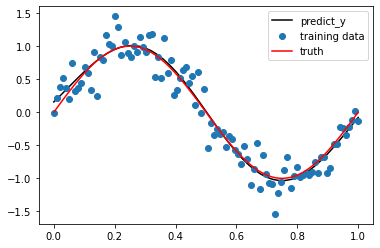

In [17]:
model.eval()
likelihood.eval()
with torch.no_grad():
    y = likelihood(model(test_x))
    y_mean = y.mean
    f, ax = plt.subplots()
    ax.plot(test_x, y_mean, 'k', label='predict_y')
    ax.plot(train_x, train_y, 'o', label='training data', linewidth=0.5)
    ax.plot(train_x, true_y,'r',label='truth')
    ax.legend()